# MNIST

In [3]:
import torch
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
import random
import argparse
from torch.utils.data import DataLoader, Subset, random_split
import os
import torch.nn as nn
import torch.optim as optim
from utils import plot_tsne

import Trainers
import autoencoders
import classifiers as clf

#### Load and prepare data

torch.Size([64, 1, 28, 28])
tensor(5)


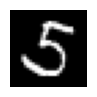

In [4]:
def freeze_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

freeze_seeds(42) #was 116

# normalize data
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5], std=[0.5])  # MNIST has 1 channel
])


dataset_path = '/datasets/cv_datasets/data'
batch_size = 64

# Load MNIST from the given path
ds_train = datasets.MNIST(root=dataset_path, train=True, download=False, transform=transform)
ds_validation = datasets.MNIST(root=dataset_path, train=False, download=False, transform=transform)

# dataset split: 
# train + test (during training)
# validation

# Split  80% train  20% test
train_size = int(0.8 * len(ds_train))  
test_size = len(ds_train) - train_size  
ds_train, ds_test = random_split(ds_train, [train_size, test_size])

# DataLoaders
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ds_validation, batch_size=batch_size, shuffle=True)


# Example - [batch_size, 1, 28, 28]
for image, label in dl_train:
    print(image.shape)
    print(label[0])
    img = image[0].squeeze(0)  
    plt.figure(figsize=(1, 1))  
    plt.imshow(img.cpu().numpy(), cmap='gray')
    plt.axis('off')  
    plt.show()

    break


## 1.2.1 

#### Initialize Autoencoder (USING CNN Autoencoder)

In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = autoencoders.Encoder_mnist().to(device)
decoder = autoencoders.Decoder_mnist().to(device)

#autoencoder = autoencoders.autoencoder(encoder, decoder).to(device)

#### Train AutoEncoder (self-supervised)

In [6]:

loss_fn = nn.L1Loss() #  mean absolute error (reconstruction error) 
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),  lr=0.001)
num_epochs = 10

trainer = Trainers.autoencoderTrainer(encoder, decoder, dl_train, dl_test, loss_fn, optimizer, num_epochs, device)
trainer.trainAutoencoder() 

Epoch 1:
    train reconstruction error: 0.0977
    Test reconstruction error: 0.0377
Epoch 2:
    train reconstruction error: 0.0364
    Test reconstruction error: 0.0299
Epoch 3:
    train reconstruction error: 0.0311
    Test reconstruction error: 0.0293
Epoch 4:
    train reconstruction error: 0.0281
    Test reconstruction error: 0.0269
Epoch 5:
    train reconstruction error: 0.0260
    Test reconstruction error: 0.0236
Epoch 6:
    train reconstruction error: 0.0248
    Test reconstruction error: 0.0220
Epoch 7:
    train reconstruction error: 0.0237
    Test reconstruction error: 0.0222
Epoch 8:
    train reconstruction error: 0.0232
    Test reconstruction error: 0.0220
Epoch 9:
    train reconstruction error: 0.0225
    Test reconstruction error: 0.0211
Epoch 10:
    train reconstruction error: 0.0221
    Test reconstruction error: 0.0222

 reconstruction error (mean absolute error, for last epoch): 0.0222


#### print tsne output

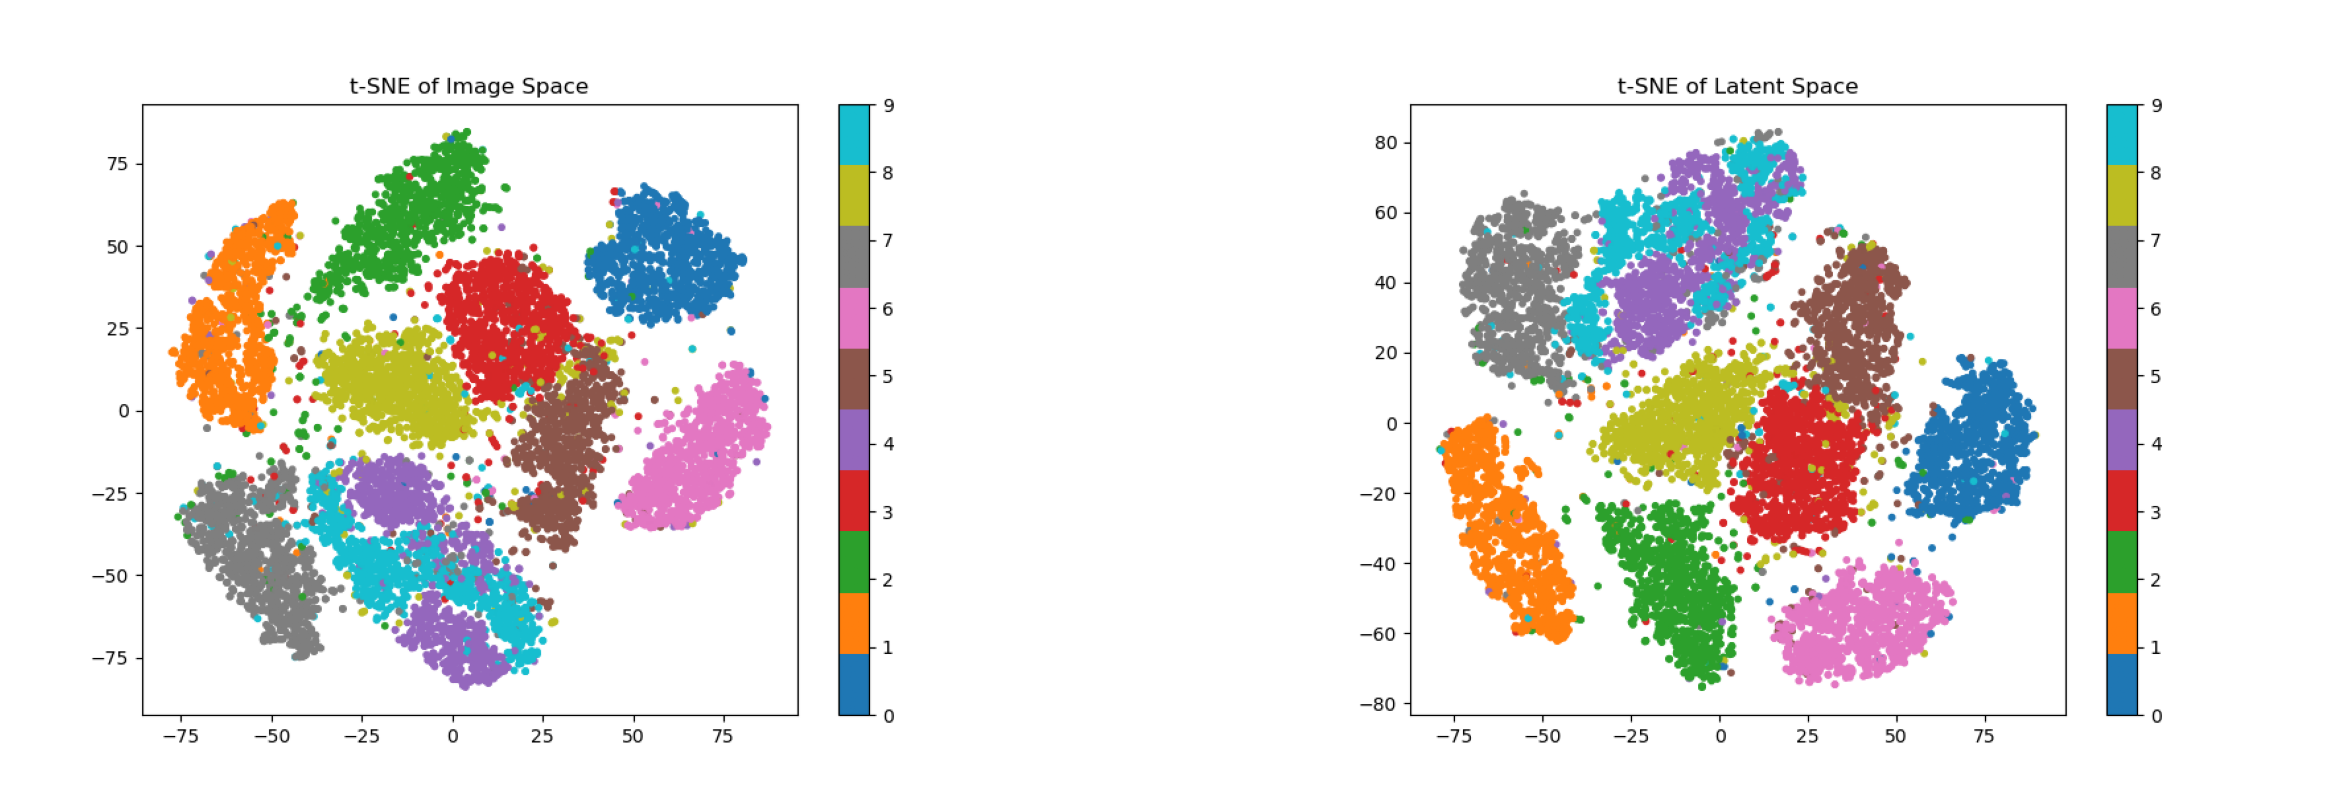

In [7]:
import matplotlib.image as mpimg

plot_tsne(encoder, dl_test, "MNIST", device)

orig_img = 'image_tsne_mnist.png'
latent_img = 'latent_tsne_mnist.png'

plt.figure(figsize=(30, 30))

img = mpimg.imread(orig_img)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')  

img = mpimg.imread(latent_img)
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.axis('off') 

plt.show()

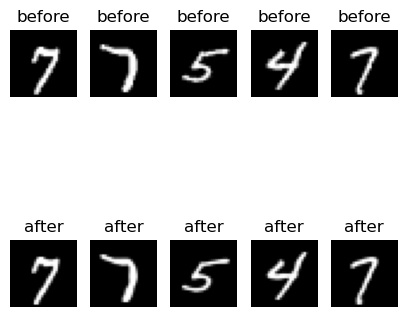

In [8]:
num_images = 5
indices = random.sample(range(len(dl_test.dataset)), num_images)

orig_img = []
rec_img = []

for idx in indices:
    img, label = dl_test.dataset[idx]
    img = img.squeeze(0)   # (1, 28, 28) -> (28, 28)
    orig_img.append(img)

    img = img.to(device)
    img = img.unsqueeze(0)
    img = img.unsqueeze(0)
    encoded_img = encoder(img)
    encoded_img = encoded_img.view(encoded_img.size(0), -1)
    r_img = decoder(encoded_img)
    rec_img.append(r_img)
    
plt.figure(figsize=(5, 5))
for i, (a, b) in enumerate(zip(orig_img, rec_img)):
    plt_axis = plt.subplot(2, num_images, i + 1)
    plt.title('before')
    plt.imshow(a.cpu().numpy(), cmap='gray')
    plt.axis('off')
    b = b.detach().cpu().numpy()
    b = b.squeeze(0)
    b = b.squeeze(0)
    plt_axis = plt.subplot(2, num_images, i + 1 + num_images)
    plt.title('after')
    plt.imshow(b, cmap='gray')
    plt.axis('off')

plt.show()


#### Initialize classifier (use pre-trained encoder)

In [9]:
classifier = clf.Classifier().to(device) 

#### Train Classifier (fully-supervised training + freeze encoder)

In [10]:
hyperparams = {
    'loss_fn': torch.nn.CrossEntropyLoss(),
    'optimizer' : optim.Adam,
    'weight_decay' : 0.0,
    'learning_rate': 0.001,  
    'num_epochs': 5,            
}

freeze_encoder = True

trainer = clf.clfTrainer(classifier, encoder, dl_train, dl_test,
                                 hyperparams, freeze_encoder, device)
train_acc, test_acc = trainer.trainClassifier()

Epoch 1:
    Train Loss: 0.4671, Train Accuracy: 87.58%
    Test Loss: 0.3537, Test Accuracy: 92.29%
Epoch 2:
    Train Loss: 0.2236, Train Accuracy: 93.54%
    Test Loss: 0.3037, Test Accuracy: 94.20%
Epoch 3:
    Train Loss: 0.1755, Train Accuracy: 94.92%
    Test Loss: 0.3175, Test Accuracy: 94.17%
Epoch 4:
    Train Loss: 0.1488, Train Accuracy: 95.58%
    Test Loss: 0.1657, Test Accuracy: 95.53%
Epoch 5:
    Train Loss: 0.1343, Train Accuracy: 95.93%
    Test Loss: 0.4411, Test Accuracy: 95.46%


#### Test Classifier on Validation

In [11]:
val_loss, val_accuracy = trainer.evalClassifier(dl_val)

Validation Loss: 0.9928, Validation Accuracy: 95.74%


#### plot downstream *classification* accuracy over - training, validation, test sets

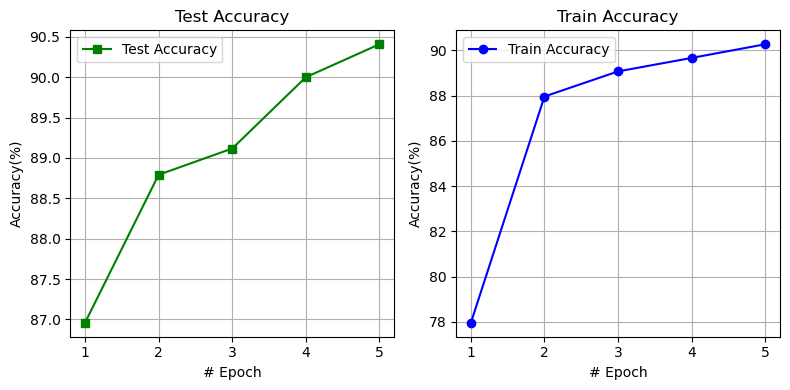

In [11]:

# Plot Train Accuracy over Epochs
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, marker='o', linestyle='-', color='b', label='Train Accuracy')
plt.title("Train Accuracy")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy(%)")
plt.grid(True)
plt.legend()

# Plot Test Loss over Iterations
plt.subplot(1, 2, 1)
plt.plot(range(1, len(test_acc) + 1), test_acc, marker='s', linestyle='-', color='g', label='Test Accuracy')
plt.title("Test Accuracy")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy(%)")
plt.grid(True)
plt.legend()

# Display the graphs
plt.tight_layout()
plt.show()


#### hyperparameter tunning

In [5]:
# piazza - can explain in words what we did in order to tune. (check again)

## 1.2.2

#### Initialize classifier + encoder

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder2 = autoencoders.Encoder_mnist().to(device)
classifier2 = clf.Classifier().to(device)

#### Train encoder & classifier JOINTLY

In [13]:
hyperparams = {
    'loss_fn': torch.nn.CrossEntropyLoss(),
    'optimizer' : optim.Adam,
    'weight_decay' : 0.0,
    'learning_rate': 0.001,  
    'num_epochs': 5,            
}
freeze_encoder = False

trainer = clf.clfTrainer(classifier2, encoder2, dl_train, dl_test,
                                 hyperparams, freeze_encoder, device)
train_acc, test_acc = trainer.trainClassifier()

Epoch 1:
    Train Loss: 0.1735, Train Accuracy: 96.60%
    Test Loss: 0.0727, Test Accuracy: 98.01%
Epoch 2:
    Train Loss: 0.0491, Train Accuracy: 98.59%
    Test Loss: 0.0510, Test Accuracy: 98.43%
Epoch 3:
    Train Loss: 0.0345, Train Accuracy: 98.94%
    Test Loss: 0.0527, Test Accuracy: 98.72%
Epoch 4:
    Train Loss: 0.0293, Train Accuracy: 99.04%
    Test Loss: 0.0731, Test Accuracy: 98.58%
Epoch 5:
    Train Loss: 0.0241, Train Accuracy: 99.20%
    Test Loss: 0.0446, Test Accuracy: 98.61%


#### view train and test accuracy 

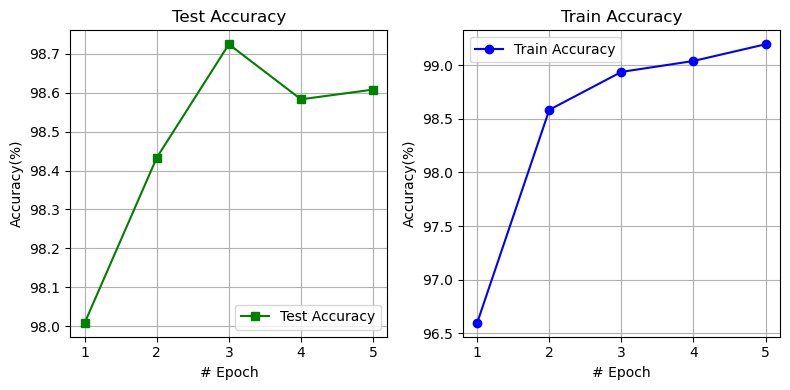

In [14]:

# Plot Train Accuracy over Epochs
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, marker='o', linestyle='-', color='b', label='Train Accuracy')
plt.title("Train Accuracy")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy(%)")
plt.grid(True)
plt.legend()

# Plot Test Loss over Iterations
plt.subplot(1, 2, 1)
plt.plot(range(1, len(test_acc) + 1), test_acc, marker='s', linestyle='-', color='g', label='Test Accuracy')
plt.title("Test Accuracy")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy(%)")
plt.grid(True)
plt.legend()

# Display the graphs
plt.tight_layout()
plt.show()

#### Evaluate on validation set

In [15]:
val_loss, val_accuracy = trainer.evalClassifier(dl_val)

Validation Loss: 0.0361, Validation Accuracy: 98.74%


## 1.2.3

#### Initialize encoder

In [9]:
# start with using the encoder from 1.2.1 , 1.2.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder3 = autoencoder.Encoder().to(device)

#### Pair dataloaders for contrastive training

In [11]:
# img_size = 28 
transform = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# dataset that return pairs 
# instead of (img,label) returns (view1, view2, label)
pair_ds_train = autoencoder.PairDataset(base_dataset=ds_train, transform=transform)

# Split  80% train  20% test
train_size = int(0.8 * len(pair_ds_train))  
test_size = len(pair_ds_train) - train_size  
pair_ds_train, pair_ds_test = random_split(pair_ds_train, [train_size, test_size])

# DataLoaders
pair_dl_train = DataLoader(pair_ds_train, batch_size=batch_size, shuffle=True)
pair_dl_test = DataLoader(pair_ds_test, batch_size=batch_size, shuffle=True)


#### Train encoder (contrastive) 

In [12]:
loss_fn = autoencoder.NTXentLoss(tmp=0.07)
optimizer = optim.Adam(encoder3.parameters(), lr=0.0001)
num_epochs = 5

autoencoder.contrastive_train( encoder3, pair_dl_train, pair_dl_test, loss_fn, optimizer, num_epochs, device)

Epoch [1/5] - Contrastive Loss: 4.1431
Epoch [2/5] - Contrastive Loss: 4.1431
Epoch [3/5] - Contrastive Loss: 4.1431
Epoch [4/5] - Contrastive Loss: 4.1431
Epoch [5/5] - Contrastive Loss: 4.1431


#### Print t-sne

#### try 1.2.3 : train with classifier jointly and then check tsne
#### GOOD LATENT SPACE RESULTS

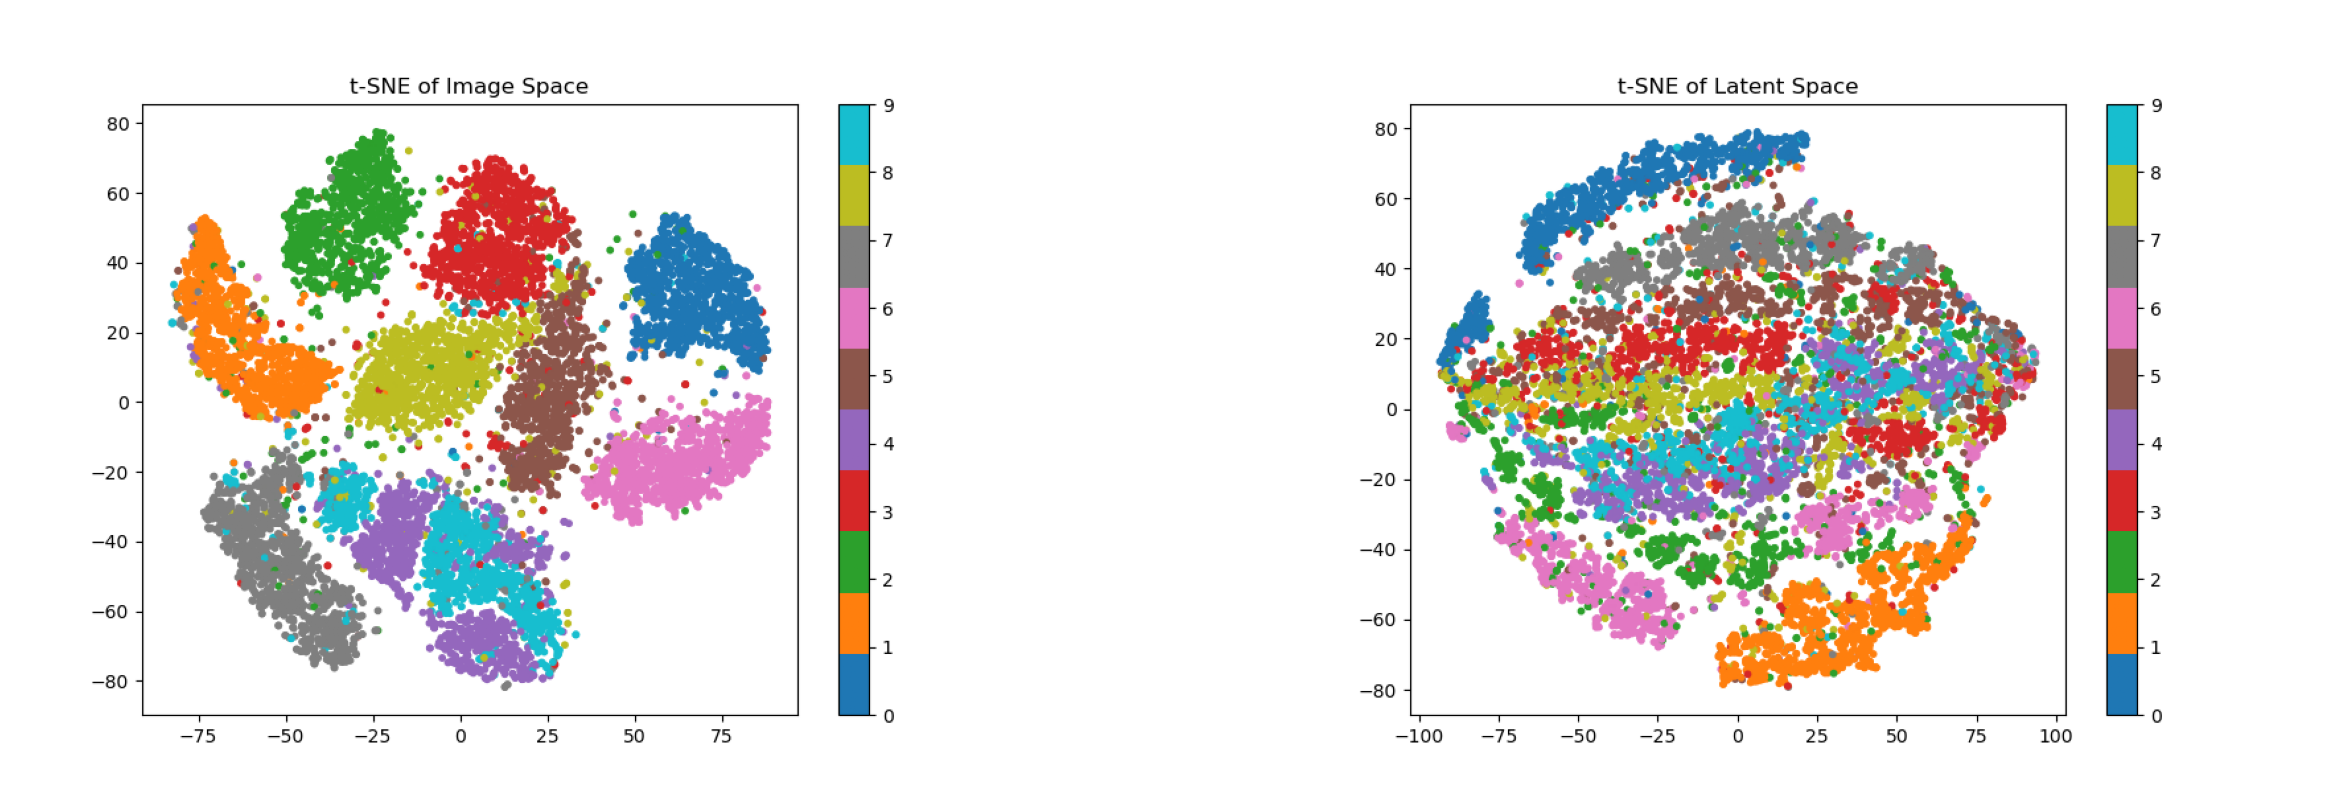

In [8]:
import matplotlib.image as mpimg

plot_tsne(encoder3, dl_test, "MNIST", device)

orig_img = 'MNIST/image_tsne.png'
reconstructed_img = 'MNIST/latent_tsne.png'

plt.figure(figsize=(30, 30))

img = mpimg.imread(orig_img)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')  

img = mpimg.imread(reconstructed_img)
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.axis('off') 

plt.show()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder3 = autoencoders.Encoder_mnist123().to(device)
classifier3 = clf.Classifier(input_size=64).to(device)

hyperparams = {
    'loss_fn': torch.nn.CrossEntropyLoss(),
    'optimizer' : optim.Adam,
    'weight_decay' : 0.0,
    'learning_rate': 0.001,  
    'num_epochs': 5,            
}
freeze_encoder = False

trainer = clf.clfTrainer(classifier3, encoder3, dl_train, dl_test,
                                 hyperparams, freeze_encoder, device)
train_acc, test_acc = trainer.trainClassifier()


Epoch 1:
    Train Loss: 0.2005, Train Accuracy: 96.25%
    Test Loss: 0.1032, Test Accuracy: 97.12%
Epoch 2:
    Train Loss: 0.0526, Train Accuracy: 98.43%
    Test Loss: 0.0569, Test Accuracy: 98.27%
Epoch 3:
    Train Loss: 0.0390, Train Accuracy: 98.78%
    Test Loss: 0.8817, Test Accuracy: 90.53%
Epoch 4:
    Train Loss: 0.0327, Train Accuracy: 98.98%
    Test Loss: 0.0456, Test Accuracy: 98.53%
Epoch 5:
    Train Loss: 0.0262, Train Accuracy: 99.20%
    Test Loss: 0.0322, Test Accuracy: 99.09%


In [8]:
# evaluate classifier
val_loss, val_accuracy = trainer.evalClassifier(dl_val)

Validation Loss: 0.0237, Validation Accuracy: 99.17%


#### Train encoder like 1.2.1 with smaller latentspace=64

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder123 = autoencoders.Encoder_mnist123().to(device)
decoder123 = autoencoders.Decoder_mnist123().to(device)

In [7]:

loss_fn = nn.L1Loss() #  mean absolute error (reconstruction error) 
#optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),  lr=0.001)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),  lr=0.001)
#optimizer = optim.Adam(autoencoder.parameters(),  lr=0.001)
num_epochs = 10

trainer = Trainers.autoencoderTrainer(encoder123, decoder123, dl_train, dl_test, loss_fn, optimizer, num_epochs, device)
trainer.trainAutoencoder() 

Epoch 1:
    train reconstruction error: 0.8324
    Test reconstruction error: 0.8321
Epoch 2:
    train reconstruction error: 0.8324
    Test reconstruction error: 0.8321
Epoch 3:
    train reconstruction error: 0.8324
    Test reconstruction error: 0.8321
Epoch 4:
    train reconstruction error: 0.8324
    Test reconstruction error: 0.8321
Epoch 5:
    train reconstruction error: 0.8324
    Test reconstruction error: 0.8321
Epoch 6:
    train reconstruction error: 0.8324
    Test reconstruction error: 0.8321
Epoch 7:
    train reconstruction error: 0.8324
    Test reconstruction error: 0.8321
Epoch 8:
    train reconstruction error: 0.8324
    Test reconstruction error: 0.8321
Epoch 9:
    train reconstruction error: 0.8324
    Test reconstruction error: 0.8321
Epoch 10:
    train reconstruction error: 0.8324
    Test reconstruction error: 0.8321

 reconstruction error (mean absolute error, for last epoch): 0.8321


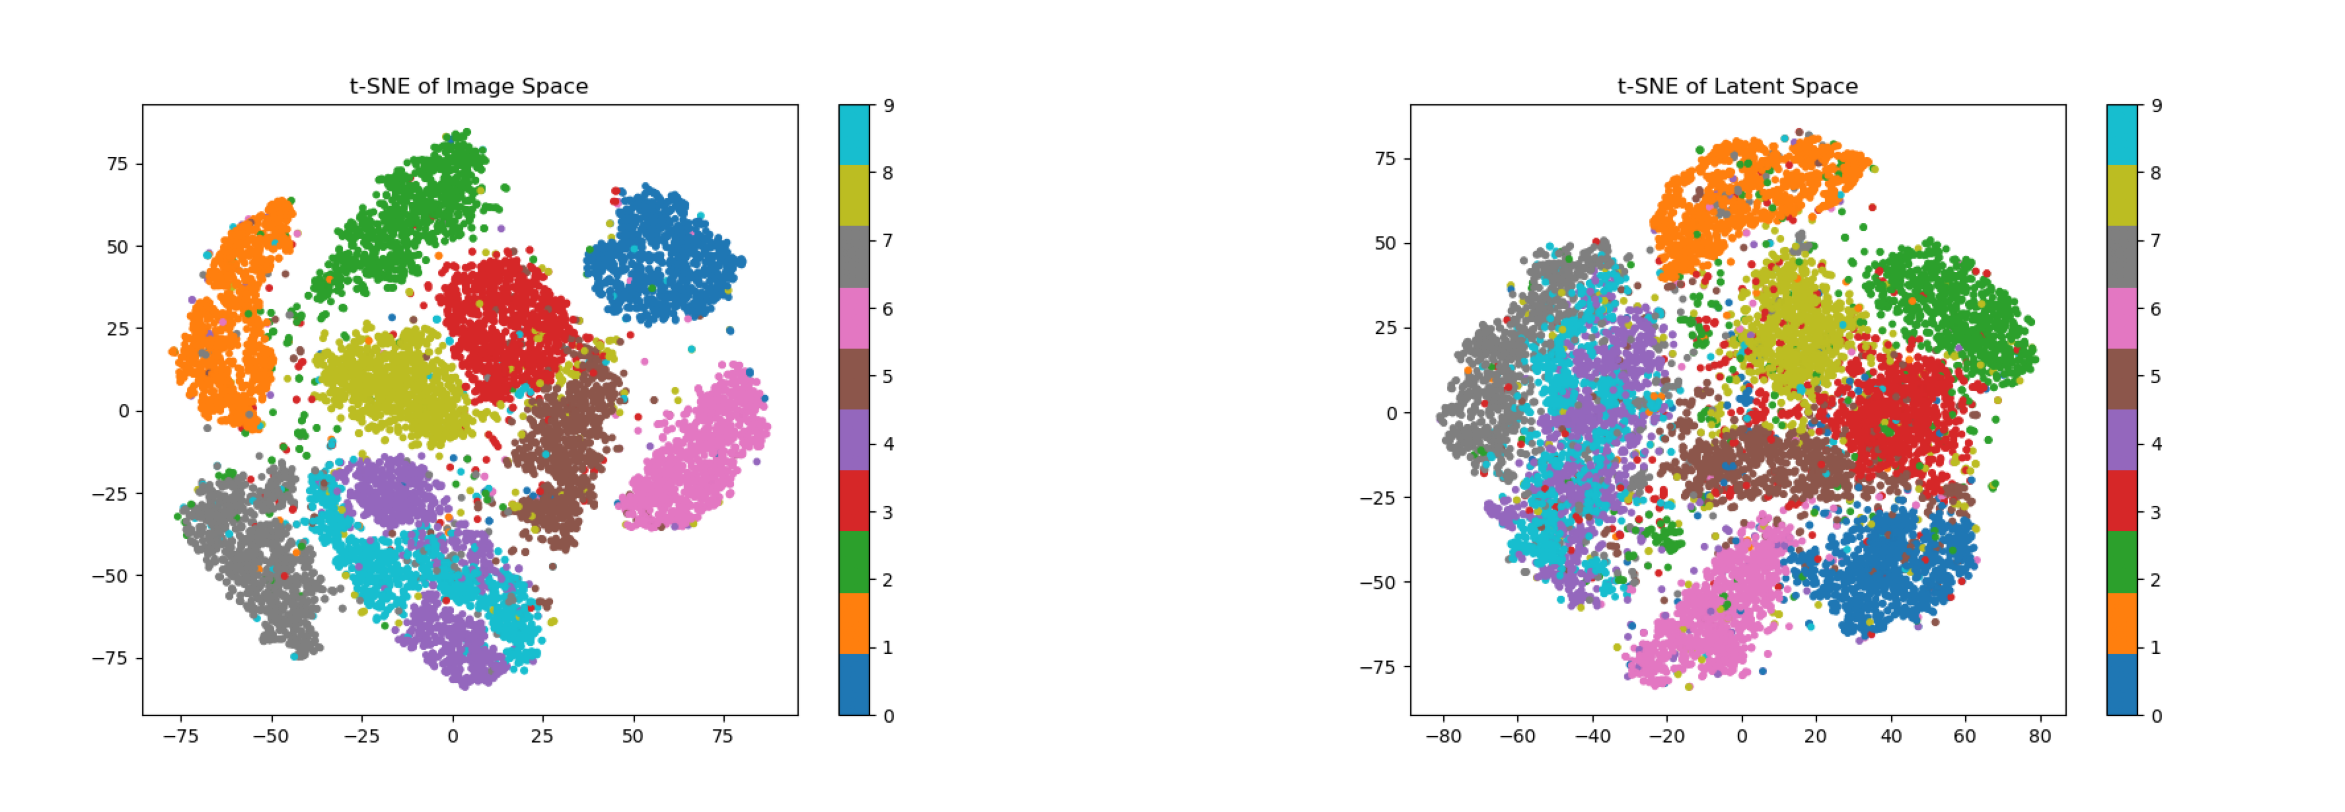

In [8]:
#### print tsne output
import matplotlib.image as mpimg

plot_tsne(encoder123, dl_test, "MNIST", device)

orig_img = 'image_tsne_mnist.png'
latent_img = 'latent_tsne_mnist.png'

plt.figure(figsize=(30, 30))

img = mpimg.imread(orig_img)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')  

img = mpimg.imread(latent_img)
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.axis('off') 

plt.show()